# Borrower reliability study

## Project description

The client is the credit department of the bank. We need to understand whether the marital status and number of children of the client affects the fact of repayment of the loan on time. Input data from the bank - statistics on the solvency of customers. The results of the study will be taken into account when building a credit scoring model - a special system that evaluates the potential borrower's ability to repay the loan to the bank.

### Research Objectives

Four hypotheticals need to be checked:
* Is there a correlation between the number of children and loan repayment on time?
* Is there a relationship between marital status and loan repayment on time?
* Is there a relationship between income level and loan repayment on time?
* How do the different purposes of the loan affect repayment on time?

### Progress of the study

In order to test these hypotheses, you need to do the following steps:
* Data review;
* Data preprocessing (filling in gaps, eliminating dibbles and anomalies);
* Hypothesis testing.

# 1. Data review

Import all the necessary libraries to work with the data.

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [70]:
data = pd.read_csv(r'D:\Yandex_Data_Analysis\Project_2\data.csv')

Let's look at the first 5 lines of the dataset.

In [71]:
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Make sure that the column names are written correctly.

In [72]:
data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

Let's look at the type of data that is in the table.

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


As you can see, the columns days_employed and total_income have missing values, because the remaining columns have the same amount of data. Let's find the number of missing values in these columns.

In [74]:
display(data.isna().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

The number of gaps in these columns is the same, which is obvious because the amount of income depends directly on the number of days worked. And since there is no information about the number of days worked, there will be no information about the income for those days.

In [118]:
display(pd.DataFrame(round((data[['days_employed','total_income']].isna().mean()*100),2),
                     columns=['zero values, %']).style.format('{:.2f}').background_gradient('coolwarm'))

,"zero values, %"
days_employed,0.00
total_income,0.00


The percentage of omissions is 10% in both columns. This is quite a lot, so we can't just delete these rows.

# 2. Data preprocessing

## 2.1.  Identification of gaps

The median value may not correctly characterize the data when some values stand out strongly among the majority (anomalies). In the case of gaps in the 'days_employed' and 'total_income' columns it is better to apply the median value, as it better reflects the objective value.

However, the 'days_employed' column contains fractional values as well as negative values. The number of days worked can only be an integer number rounded up. As for the negative values, it is difficult to specify the exact cause. You should check with the developer, who provided the data.

To begin with, make all numbers in the 'days_employed' column positive and integers, rounding them up.

In [77]:
data['days_employed'] = round(data['days_employed'].abs())
data.loc[11:13]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
11,0,793.0,40,среднее,1,женат / замужем,0,F,сотрудник,0,77069.234271,покупка коммерческой недвижимости
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
13,0,1847.0,54,неоконченное высшее,2,женат / замужем,0,F,сотрудник,0,130458.228857,приобретение автомобиля


Let's check if the omissions in the 'days_employed' column are related to the age of the clients. To do this, let's write a function that splits the age of the clients into groups:
* 'children' if the age is under 18;
* 'adults' - if the age is between 19 and 64;
* 'pensioners' if they are 65 and older.
Let's save the obtained data with categories into a separate column 'age_group'.

In [78]:
def age_group(age):
    if age <= 18:
        return 'children'
    if age <= 64:
        return 'adults'
    return 'retired' 
group_age = data['dob_years'].apply(age_group)
data.insert(3, 'age_group', group_age)
display(data[11:14]) 

,children,days_employed,dob_years,age_group,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
11,0,793.0,40,adults,среднее,1,женат / замужем,0,F,сотрудник,0,77069.234271,покупка коммерческой недвижимости
12,0,NaN,65,retired,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
13,0,1847.0,54,adults,неоконченное высшее,2,женат / замужем,0,F,сотрудник,0,130458.228857,приобретение автомобиля


Now let's find out if there is a relationship between the blanks in 'days_employed' and the age categories. Perhaps some empty values can simply be zeroed out, which corresponds to the 'retired' category.

In [79]:
data.groupby('age_group')['days_employed'].count()

age_group
adults      18442
children       91
retired       818
Name: days_employed, dtype: int64

As you can see, there are only 818 retired. Let's check how many lines contain empty values associated with retired.

In [80]:
data[data['age_group'] == 'retired'].isna().sum()

children             0
days_employed       81
dob_years            0
age_group            0
education            0
education_id         0
family_status        0
family_status_id     0
gender               0
income_type          0
debt                 0
total_income        81
purpose              0
dtype: int64

So there are a total of 81 lines with empty values in two columns.

Before filling in the blanks, let's check what anomalies are in the data.

## 2.2. Search for anomalies

Let's check what anomalies there are in the days_employed column for the 3 age groups. Let's look at the maximum length of service of each group.

In [81]:
print('retired -', data.loc[data['age_group'] == 'retired','days_employed'].max())
print('adults -', data.loc[data['age_group'] == 'adults','days_employed'].max())
print('children -', data.loc[data['age_group'] == 'children','days_employed'].max())

retired - 401716.0
adults - 401755.0
children - 400992.0


As you can see the length of service more than 400,000 days (over 1000 years) can not be. Lines containing such values are the first anomalies in the data. It would be logical to assume that the length of service of the average person can not exceed 34 years or 12410 days. Let's see how many lines exceed this value.

In [82]:
data.loc[data['days_employed'] >12410,'days_employed'].count()

3517

There are quite a lot of such emissions, so they cannot be deleted. Let's replace these values with the objectively maximum possible length of service - 12410.

In [83]:
data.loc[data['days_employed'] >12410,'days_employed'] = 12410
print(data['days_employed'].max())

12410.0


Now check the total_income column for anomalies.

In [84]:
print(data['total_income'].max())
print(data['total_income'].min())
print(data.loc[data['total_income'] == 0,'total_income'].count())

2265604.028722744
20667.26379327158
0


There are no anomalies in this column, but there are missing values.

We will replace the zero values with medians relative to each age group.

Check the anomalies in the 'children' column.

In [85]:
display(data['children'].value_counts())
display(data['children'].isna().sum())

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

0

The 'children' column has very strange values, for example, the number of children cannot be negative. And it is unlikely that someone can have 20 children. Let's replace the rows where -1 is found with 1, and where 20 is found with 2.

In [86]:
data['children'] = data['children'].replace(-1,1)
data['children'] = data['children'].replace(20,2)
data['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

Let's check the column with the gender.

In [87]:
display(data['gender'].value_counts())
display(data['gender'].isna().sum())

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

0

As you can see, there are no empty lines, but there is one obscure value that is worth deleting.

In [88]:
xna = data[data['gender'] == 'XNA'].index
data = data.drop(index=xna).reset_index(drop=True)
display(data[10700:10703])

,children,days_employed,dob_years,age_group,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10700,1,513.0,37,adults,высшее,0,женат / замужем,0,F,компаньон,0,174396.822139,ремонт жилью
10701,0,12410.0,60,adults,среднее,1,гражданский брак,1,F,пенсионер,0,108125.202905,свадьба
10702,0,3620.0,35,adults,среднее,1,женат / замужем,0,F,сотрудник,0,89817.943638,получение образования


Now let's check the age column.

In [89]:
display(data['dob_years'].value_counts())
display(data['dob_years'].isna().sum())

35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    263
23    254
65    194
66    183
22    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

0

There are no empty values, but there is an age of 0. There shouldn't be. There are only 101 such values, so you can simply delete these lines.

In [90]:
data = data[data.dob_years != 0]
display(data['dob_years'].value_counts().tail(11))

21    111
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

There are no more anomalies in the dataset. Now let's eliminate the anomalies detected.

## 2.3 Eliminating anomalies

Replace the missing values in the days_employed column with the median length of service for each age group. First, find out the median years of service for each group.

In [91]:
print('median of retired length of service -', data.loc[data['age_group'] == 'retired','days_employed'].median())
print('median adult length of service -', data.loc[data['age_group'] == 'adults','days_employed'].median())
print('median of children service -', data.loc[data['age_group'] == 'children','days_employed'].median())

median of retired length of service - 12410.0
median adult length of service - 2051.0
median of children service - nan


All lines with the category 'children' have no values. This was expected, because earlier we got rid of all rows with age 0. So the category 'children' disappeared by itself, as it corresponded to a single value - 0.

Let's see how many empty values are left in the 'retired' and 'adults' categories.

In [92]:
print('retired length of service nan -', data.loc[data['age_group'] == 'retired','days_employed'].isna().sum())
print('adult length of service nan-', data.loc[data['age_group'] == 'adults','days_employed'].isna().sum())

retired length of service nan - 81
adult length of service nan- 2083


There are quite a lot of empty values, you can't delete them. Replace them with the median values relative to each category. Then check the result.

In [93]:
data['days_employed'].fillna(data.groupby('age_group')['days_employed'].transform('median'),inplace= True)

print('retired length of service nan -', data.loc[data['age_group'] == 'retired','days_employed'].isna().sum())
print('adult length of service nan -', data.loc[data['age_group'] == 'adults','days_employed'].isna().sum())

retired length of service nan - 0
adult length of service nan - 0


There are no empty values in the 'days_employed' column. Let's do the same procedure with the 'total income' column.

In [94]:
data['total_income'].fillna(data.groupby('age_group')['total_income'].transform('median'),inplace= True)

print('retired income nan -', data.loc[data['age_group'] == 'retired','total_income'].isna().sum())
print('adults income nan-', data.loc[data['age_group'] == 'adults','total_income'].isna().sum())

retired income nan - 0
adults income nan- 0


### Thus we got rid of all anomalies and empty values in the dataset.

## 2.3. Removing duplicates

Let's check how many obvious duplicates there are in the table.

In [95]:
data.duplicated().sum()

54

Their number is small, so you can delete lines that contain obvious duplicates.

In [96]:
data = data.drop_duplicates().reset_index(drop=True)

Let's check the other columns for implicit duplicates, such as 'education' and 'purpose'. Let's start with 'education'.

In [97]:
data['education'].sort_values().unique()

array(['ВЫСШЕЕ', 'Высшее', 'НАЧАЛЬНОЕ', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ',
       'Начальное', 'Неоконченное высшее', 'СРЕДНЕЕ', 'Среднее',
       'УЧЕНАЯ СТЕПЕНЬ', 'Ученая степень', 'высшее', 'начальное',
       'неоконченное высшее', 'среднее', 'ученая степень'], dtype=object)

Let's convert all values to lower case.

In [98]:
data['education'] = data['education'].str.lower()
data['education'].sort_values().unique()

array(['высшее', 'начальное', 'неоконченное высшее', 'среднее',
       'ученая степень'], dtype=object)

Let's check if there are still complete duplicates after replacing the register.

In [99]:
data.duplicated().sum()

17

In [100]:
data = data.drop_duplicates().reset_index(drop=True)

Check what unique values there are in the 'purpose' column

In [101]:
data.groupby('purpose')['purpose'].count()

purpose
автомобили                                476
автомобиль                                490
высшее образование                        449
дополнительное образование                458
жилье                                     640
заняться высшим образованием              493
заняться образованием                     407
на покупку автомобиля                     466
на покупку подержанного автомобиля        478
на покупку своего автомобиля              502
на проведение свадьбы                     764
недвижимость                              629
образование                               444
операции с жильем                         646
операции с коммерческой недвижимостью     648
операции с недвижимостью                  672
операции со своей недвижимостью           627
покупка жилой недвижимости                603
покупка жилья                             640
покупка жилья для сдачи                   649
покупка жилья для семьи                   637
покупка коммерческой недви

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21352 entries, 0 to 21351
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21352 non-null  int64  
 1   days_employed     21352 non-null  float64
 2   dob_years         21352 non-null  int64  
 3   age_group         21352 non-null  object 
 4   education         21352 non-null  object 
 5   education_id      21352 non-null  int64  
 6   family_status     21352 non-null  object 
 7   family_status_id  21352 non-null  int64  
 8   gender            21352 non-null  object 
 9   income_type       21352 non-null  object 
 10  debt              21352 non-null  int64  
 11  total_income      21352 non-null  float64
 12  purpose           21352 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.1+ MB


Assign string values to all values in the targets column.

In [103]:
data['purpose'] = data['purpose'].astype(str)

Let's create a function that combines similar goals into categories. Let's save them in a new column 'purpose_category'.

In [104]:
def replace_wrong_values(purpose):
    
    if 'автомоб' in purpose:
        return 'операции с автомобилем'
    elif 'образов' in purpose:
        return 'получение образования'
    elif 'свад' in purpose:
        return 'проведение свадьбы'
    else:
        return 'операции с недвижимостью'
    
data['purpose_category'] = data['purpose'].apply(replace_wrong_values)


display(data.head(5))            

,children,days_employed,dob_years,age_group,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
0,1,8438.0,42,adults,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,операции с недвижимостью
1,1,4025.0,36,adults,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,операции с автомобилем
2,0,5623.0,33,adults,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,операции с недвижимостью
3,3,4125.0,32,adults,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,получение образования
4,0,12410.0,53,adults,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,проведение свадьбы


Let's see how many values fit into each category

In [105]:
data['purpose_category'].value_counts()

операции с недвижимостью    10763
операции с автомобилем       4284
получение образования        3995
проведение свадьбы           2310
Name: purpose_category, dtype: int64

### In this way we have cleared the table of all possible duplicates

Let's form two new dataframes:

* In the first, each unique value from education will correspond to a unique value of education_id;
* In the second, each unique value from family_status corresponds to a unique value of family_status_id.

In [106]:
edu_data = data[['education','education_id']]
family_data = data[['family_status','family_status_id']]
display(edu_data.head(5))
display(family_data.head(5))

,education,education_id
0,высшее,0
1,среднее,1
2,среднее,1
3,среднее,1
4,среднее,1


,family_status,family_status_id
0,женат / замужем,0
1,женат / замужем,0
2,женат / замужем,0
3,женат / замужем,0
4,гражданский брак,1


As you can see, both dataframes contain duplicates. Let's get rid of them.

In [107]:
edu_data = edu_data.drop_duplicates().reset_index(drop=True)
family_data = family_data.drop_duplicates().reset_index(drop=True)
display(edu_data.head())
display(family_data.head())

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


Let's get rid of the education and family_status columns from the original dataframe.

In [108]:
data.drop(['education', 'family_status'], axis =1).head(5)

,children,days_employed,dob_years,age_group,education_id,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
0,1,8438.0,42,adults,0,0,F,сотрудник,0,253875.639453,покупка жилья,операции с недвижимостью
1,1,4025.0,36,adults,1,0,F,сотрудник,0,112080.014102,приобретение автомобиля,операции с автомобилем
2,0,5623.0,33,adults,1,0,M,сотрудник,0,145885.952297,покупка жилья,операции с недвижимостью
3,3,4125.0,32,adults,1,0,M,сотрудник,0,267628.550329,дополнительное образование,получение образования
4,0,12410.0,53,adults,1,1,F,пенсионер,0,158616.077870,сыграть свадьбу,проведение свадьбы


Create a function that distributes borrowers into groups based on their income from 'A' to 'E', where 'A' is the most reliable customers and 'E' is the most insolvent.
* 0–30000 — 'E';
* 30001–50000 — 'D';
* 50001–200000 — 'C';
* 200001–1000000 — 'B';
* 1000001 and higher — 'A'.

In [109]:
def creditors (income):
    if income <= 30000:
        return 'E'
    elif 30001 <= income <= 50000:
        return 'D'
    elif 50001<= income <=200000:
        return 'C'
    elif 200001<= income <=1000000:
        return 'B'
    else:
        return 'A'
    
data['total_income_category'] = data['total_income'].apply(creditors)


display(data.head(5))

,children,days_employed,dob_years,age_group,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category,total_income_category
0,1,8438.0,42,adults,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,операции с недвижимостью,B
1,1,4025.0,36,adults,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,операции с автомобилем,C
2,0,5623.0,33,adults,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,операции с недвижимостью,C
3,3,4125.0,32,adults,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,получение образования,B
4,0,12410.0,53,adults,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,проведение свадьбы,C


# 3. Hypothesis testing

## 3.1 Is there a correlation between the number of children and repayment on time?

To test this hypothesis, let's look at the relationship between the 'debt' and 'children' columns, where 1 means that the loan was outstanding and 0 means that it was not. For convenience, let's create a separate dataframe containing only these columns.

In [110]:
debt_children = data[['children', 'debt']]
debt_children_pivot = debt_children.pivot_table(index=['children'], values = 'debt', aggfunc = ['sum','count'])
debt_children_pivot

,sum,count
,debt,debt
children,,
0,1058,14021
1,442,4839
2,202,2114
3,27,328
4,4,41
5,0,9


As you can see from the table, families with 5 children always pay their loans on time. Let's see how the shares of debtors are distributed in other family groups.

In [111]:
debt_children_pivot['share'] = (debt_children_pivot['sum']/debt_children_pivot['count'])*100
display(debt_children_pivot.style.format('{:.2f}'))

,sum,count,share
,debt,debt,
children,,,
0,1058.00,14021.00,7.55
1,442.00,4839.00,9.13
2,202.00,2114.00,9.56
3,27.00,328.00,8.23
4,4.00,41.00,9.76
5,0.00,9.00,0.00


### Conclusion

* Obviously, the highest percentage of debtors is in families with 4 children.
* The most solvent clients are those who have 5 children.
* Childless clients are better at paying back loans on time, compared to those who have children.

**<u>The hypothesis is correct. There is a relationship between the number of children and repayment on time<u>**

## 3.2. Is there a correlation between marital status and loan repayment on time?

To test this hypothesis, let's look at the relationship between the 'debt' and 'family_status' columns. For convenience, let's create a separate data frame containing only these columns. This time we will use data grouping instead of crosstabs.

In [112]:
debt_family = data[['family_status', 'debt']]
debt_family_sum = debt_family.groupby('family_status').sum()
debt_family_count = debt_family.groupby('family_status').count()
debt_family_result = debt_family_sum.merge(debt_family_count, on='family_status', how='left')
debt_family_share = (debt_family_sum / debt_family_count)*100
debt_family_result['debt_family_share'] = debt_family_share
debt_family_result = debt_family_result.rename(columns={'debt_x' : 'sum', 'debt_y':'count'})
debt_family_result.style.format('{:.2f}')


,sum,count,debt_family_share
family_status,,,
Не женат / не замужем,273.00,2794.00,9.77
в разводе,85.00,1185.00,7.17
вдовец / вдова,62.00,954.00,6.50
гражданский брак,386.00,4129.00,9.35
женат / замужем,927.00,12290.00,7.54


### Conclusion

* As can be seen from the table, the most debtors are those who are not married or have never been married;
* The most reliable clients are those who are widowed;
* It is also obvious that the pivot method is much more compact for the construction of summary tables.

**<u>The hypothesis is correct. The relationship between marital status and loan repayment on time<u>**

## 3.3. Is there a correlation between income level and loan repayment on time?

To test this hypothesis, let's look at the relationship between the 'debt' and 'total_income_category' columns. For convenience, let's create a separate dataframe containing only these columns.

In [113]:
debt_income = data[['total_income_category', 'debt']]
debt_income_pivot = debt_income.pivot_table(index=['total_income_category'], values = 'debt', aggfunc = ['sum','count'])
debt_income_pivot['share'] = (debt_income_pivot['sum']/debt_income_pivot['count'])*100
debt_income_pivot.style.format('{:.2f}')

,sum,count,share
,debt,debt,
total_income_category,,,
A,2.00,25.00,8.00
B,355.00,5014.00,7.08
C,1353.00,15943.00,8.49
D,21.00,348.00,6.03
E,2.00,22.00,9.09


## Вывод

* Результаты показывают, что наибольшее число должников находится в группе людей с самым низким уровнем дохода;
* Как ни странно но среди людей с самым высоким уровнем дохода тоже находится довольно много должников;
* Самые платежеспособные клиенты те, у кого уровень дохода чуть выше минимального (от 30001 до 50000)

**<u>Гипотеза верна частично. Вопреки здравому смыслу, самая богатая группа людей не охотно возвращают кредиты в срок. Однако, как и ожидалось, самая бедная группа населения тоже задерживает выплаты.<u>**

## 3.4. Как разные цели кредита влияют на его возврат в срок?

По тому же принципу, что и в предыдущих случиях, проверим данную гипотизы посредством взаимосвязи между столбцами 'debt' и 'purpose_category'.

In [48]:
debt_purpose = data[['purpose_category', 'debt']]
debt_purpose_pivot = debt_purpose.pivot_table(index=['purpose_category'], values = 'debt', aggfunc = ['sum','count'])
debt_purpose_pivot['share'] = (debt_purpose_pivot['sum']/debt_purpose_pivot['count'])*100
debt_purpose_pivot.style.format('{:.2f}')

,sum,count,share
,debt,debt,
purpose_category,,,
операции с автомобилем,400.00,4284.00,9.34
операции с недвижимостью,779.00,10763.00,7.24
получение образования,370.00,3995.00,9.26
проведение свадьбы,184.00,2310.00,7.97


## Conclusion

* The results of the analysis show that the most frequently delayed payments are those people who took a loan for car transactions;
* The best repayment rate is for loans related to real estate;
* Loans taken out for education and automobiles are paid back in about the same way.

**<u>Hypothesis justified. Indeed, loans taken out for different purposes are paid back differently.<u>**

# 4. General conclusion

To make the results clearer, we will use the graphs from the seaborn library.

## 4.1. Relationship between the number of children and not repaying the loan on time

<AxesSubplot:xlabel='children', ylabel='share'>

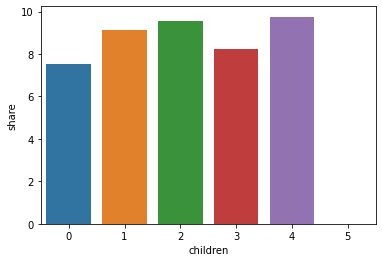

In [114]:
debt_children_pivot
seaborn.barplot(x=debt_children_pivot.index, y="share", data=debt_children_pivot)

## 4.2. Relationship between marital status and failure to repay a loan on time

[Text(0, 0, 'Не женат / не замужем'),
 Text(1, 0, 'в разводе'),
 Text(2, 0, 'вдовец / вдова'),
 Text(3, 0, 'гражданский брак'),
 Text(4, 0, 'женат / замужем')]

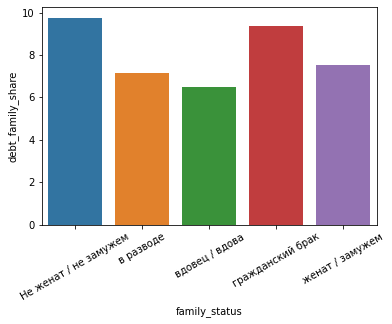

In [115]:
ax = seaborn.barplot(x=debt_family_result.index, y="debt_family_share", data=debt_family_result)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

## 4.3. Relationship between the purpose of the loan and its failure to be repaid on time

[Text(0, 0, 'операции с автомобилем'),
 Text(1, 0, 'операции с недвижимостью'),
 Text(2, 0, 'получение образования'),
 Text(3, 0, 'проведение свадьбы')]

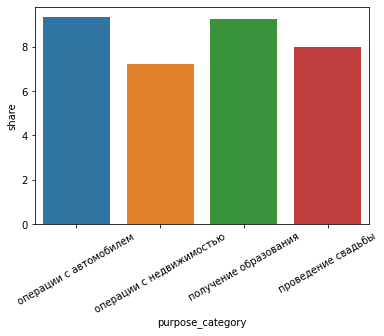

In [116]:
ax = seaborn.barplot(x=debt_purpose_pivot.index, y="share", data=debt_purpose_pivot,)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

## 4.4. The relationship between income and repayment on time

<AxesSubplot:xlabel='total_income_category', ylabel='share'>

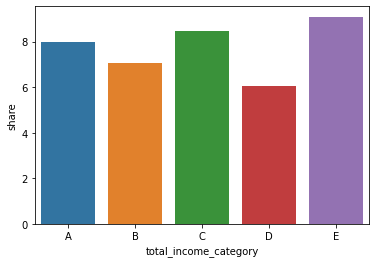

In [117]:
seaborn.barplot(x=debt_income_pivot.index, y="share", data=debt_income_pivot)

# 5. Findings
The results of the study showed that there are several factors that affect the repayment of the loan on time:
* marital status;
* number of children in the family;
* amount of income;
* purpose of the loan

#### All of the hypotheses put forward were confirmed, some only partially. The general trend is that in each selected group of creditors the percentage of clients who are overdue on loans ranges from 6% to 9.5%.

*Based on the conducted analysis we can draw up a portrait of **ideal client** - childless, widowed or divorced people who take credit on the real estate and with income from 30 to 50 thousand rubles.
*Also we can draw the opposite portrait of an **undesirable customer** - with four children, unmarried, car loan and with an income of 50 to 200 thousand*